In [1]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import numpy as np
import pandas as pd  
from urllib import request
from bs4 import BeautifulSoup

In [3]:
URL = "https://www.food.com"

robots = request.urlopen(URL+"/robots.txt").read().decode('utf8')
robots = robots.split("\n\n")[1]

In [4]:
disallowed = []
for line in robots.split("\n"):
    m = re.match(r'^Disallow: (.*)$',line.strip())
    if m:
        this_url = m.group(1)
        # convert the disallowed URLs to regular expressions
        this_url = re.sub(r'\*',".*",this_url)
        this_url = re.sub(r'\?',"\?",this_url)
        this_url = re.sub(r'\/$',"",this_url)
        if (not this_url.startswith("http")): this_url = URL+this_url 
        disallowed.append(this_url)

In [5]:
# open the main page of Food.com
if (not URL in disallowed) and (not "/" in disallowed):
    food = request.urlopen(URL).read().decode('utf8')

In [6]:
# retrieve url for each cuisine main page

url_set = dict()

cuisine = ('mexican', 'italian', 'indian', 'thai', 'korean', 'french', 'latin-american', 'chinese', 'japanese', 'spanish')
# use Beautiful Soup to find all <a> tags in the page
for atag in BeautifulSoup(food,"html.parser").find_all('a'):
    href = atag.get('href')
    if href==None: continue

    # Add this hypertext reference to the list, if it's allowed
    allowed = 1
    for disallow in disallowed:
        if re.match(r'^'+disallow+'$',href): 
            allowed = 0
    # preserve only meaningful web pages of news
    # if allowed and re.match(r'^' + URL, href): 
    
    for c in cuisine:
        # some of the URL are using -food pattern meanwhile the other ones are using -recipe
        if allowed and c+'-food' in href:
            url_set[c]=URL + href
        elif allowed and c+'-recipe' in href:
            url_set[c]=URL + href

In [7]:
# retrieve content of each main page of the cuisine

link_contents = {}

for i in cuisine:
    if (not URL in disallowed) and (not "/" in disallowed):
        link_contents[i] = request.urlopen(url_set[i]).read().decode('utf8')

In [8]:
# retrieve links for recipe inside each cuisine

links = {}

for i in cuisine:
    recipes = []
    for atag in BeautifulSoup(link_contents[i],"html.parser").find_all('a'):
        href = atag.get('href')
        if href==None: continue
            
        allowed = 1
        for disallow in disallowed:
            if re.match(r'^'+disallow+'$',href): 
                allowed = 0
            
        if allowed and 'www.food.com/recipe/' in href:
            recipes.append(href)
            
    links[i] = recipes

In [15]:
# retrieve full recipes
# this may take some time to run

allrecipes = []

def crawl_recipe(c):
    for i in range (0,len(links[c])):
        recipe=[]
        
        # reading the content of the web page
        content = request.urlopen(links[c][i]).read()
        soup = BeautifulSoup(content, 'lxml')
        
        # retrieve the dish title
        title = soup.find('div', class_= 'layout__item title svelte-mq22ro').h1.text
        recipe.append(title)
        
        # retrieve the list of ingredients
        start = 'window.mdManager.setParameter("ingredients", "'
        end = '");window.mdManager.setParameter("keywordids",'
        results = str(soup.find_all('script'))
        ingredients = (results.split(start))[1].split(end)[0]
        recipe.append(ingredients)
        
        # input the cuisine name as identifier
        recipe.append(c)
        # input the recipe to the final var
        allrecipes.append(recipe)

        
# crawl each cuisine
for item in cuisine:
    crawl_recipe(item)

AttributeError: 'NoneType' object has no attribute 'h1'

In [12]:
# export final result to csv

df = pd.DataFrame(allrecipes)
headerList = ['Name', 'Ingredients', 'Cuisine']
df.to_csv('all_recipes.csv', header=headerList,index=False)

In [10]:
import pandas
from sklearn.ensemble import RandomForestClassifier as RFC
import matplotlib.pyplot as plt
import numpy as np
import random
import gc

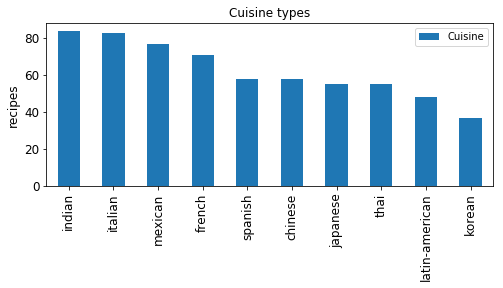

In [37]:
df=pd.read_csv('all_recipes.csv')  
train_df=df
submission_df=pd.read_csv('Out of Sample.csv')
ax = train_df['Cuisine'].value_counts().plot(kind='bar', title ="Cuisine types", figsize=(8, 3), legend=True, fontsize=12)
ax.set_ylabel("recipes", fontsize=12)
plt.show()

C:\Users\virgi\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\virgi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


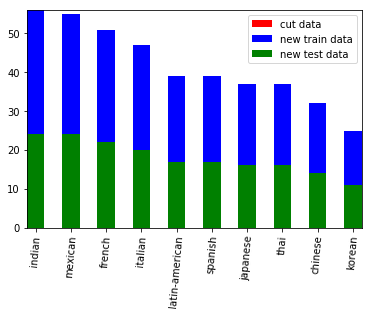

In [38]:
# We divide the original train data into 3 sets: 
# test_df will contain 30% recipes for each cuisine type
# train_df will contain 70% recipes for each cuisine type
# cut_df will contain the remaining data (could be used as another test set...) if exist

new_test_df=pandas.DataFrame()
new_train_df=pandas.DataFrame()
cut_df=pandas.DataFrame()
cut_percentage=0.05  
for cuisine in train_df['Cuisine'].drop_duplicates().values :
    temp=pandas.DataFrame()
    temp=train_df[train_df['Cuisine']==cuisine]
    rows_test = random.sample(list(temp.index), round(0.3*(1-cut_percentage)*len(train_df[train_df['Cuisine']==cuisine])))
    new_test_df=new_test_df.append(temp.ix[rows_test])
    rows_train= random.sample(list(temp.drop(rows_test).index), round(0.7*(1-cut_percentage)*len(train_df[train_df['Cuisine']==cuisine])))
    new_train_df=new_train_df.append(temp.ix[rows_train])
    rows=rows_test+rows_train
    cut_df=cut_df.append(temp.drop(rows))
    del temp

ax=plt.subplot()
CuisineCall = list(range(0,len(cut_df['Cuisine'].value_counts().index)))
LABELS=cut_df['Cuisine'].value_counts().index
ax.bar(CuisineCall,cut_df['Cuisine'].value_counts(),width=0.5,color='r',align='center',label='cut data')
ax.bar(CuisineCall,new_train_df['Cuisine'].value_counts(),width=0.5,color='b',align='center', label='new train data')
ax.bar(CuisineCall,new_test_df['Cuisine'].value_counts(),width=0.5,color='g',align='center',label='new test data')
plt.xticks(CuisineCall, LABELS,rotation=85)
ax.autoscale(tight=True)
plt.legend()

plt.show()

In [39]:
new_train_df


,Name,Ingredients,Cuisine
26,Horchata,"blanched almonds,cinnamon sticks,ice,milk,suga...",mexican
13,El Rey's Fish Tacos,"avocados,baking powder,beer,cabbage,canola oil...",mexican
55,Tamales De Pollo Con Chile Verde- Green Chile ...,"baking powder,chicken,chicken broth,cooked chi...",mexican
35,Corn Tortillas,"masa harina flour,salt,water",mexican
28,"Sopa De Lima (Merida, Yucatan)","avocados,chicken breasts,chicken broth,limes,o...",mexican
62,Chocolate Clams and Salsa,"black beans,chipotle peppers,clams,Dijon musta...",mexican
14,Capirotada,"cheddar cheese,cinnamon sticks,French bread,gr...",mexican
63,Salsa Borracha or Drunk Salsa,"beer,butter,chili powder,diced tomatoes,garlic...",mexican
71,Street Tacos- Authentic Mexican No Cheese Ch...,"boneless skinless chicken,chicken broth,cilant...",mexican
72,Tacu Tacu,"brown rice,chickpeas,garlic cloves,olive oil,p...",mexican


In [40]:
try: 
    del train_df
except:pass;gc.collect()

# Get the ingredients column from the new train data and create the list of all existing ingredients
new_ingredients=new_train_df.Name
rawlist=[item for sublist in new_ingredients.ravel() for item in sublist] #convert the ingredients list of lists into a list
ingredients=list(set(rawlist)) #remove duplicates

for ing in ingredients:
    vector=[]
    # loop for train data
    for recipe in new_train_df.Name: 
        if ing in recipe:
            vector.append(1)
        else:
            vector.append(0)
    new_train_df[ing]=pandas.Series(vector,index=new_train_df.index) # Adds column containing 0 and 1's for this ingredient
    
    # loop for test data
    vector=[]
    for recipe in new_test_df.Name:
        if ing in recipe:
            vector.append(1)
        else:
            vector.append(0)
    new_test_df[ing]=pandas.Series(vector,index=new_test_df.index) # Adds column containing 0 and 1's for this ingredient
   
    # loop for cut data
    vector=[]
    for recipe in cut_df.Name:
        if ing in recipe:
            vector.append(1)
        else:
            vector.append(0)
    cut_df[ing]=pandas.Series(vector,index=cut_df.index) # Adds column containing 0 and 1's for this ingredient

    # While we are here, let's build also the submission data
    vector=[]
    for recipe in submission_df.recipe_title:
        if ing in recipe:
            vector.append(1)
        else:
            vector.append(0)
    submission_df[ing]=pandas.Series(vector,index=submission_df.index) # Adds column containing 0 and 1's for this ingredient

# useless columns removal
new_train_df#=new_train_df.drop('Ingredients',1)

new_test_df#=new_test_df.drop('Ingredients',1)

cut_df#=cut_df.drop('Ingredients',1)

new_test_df#=submission_df.drop('ingredients',1)

new_train_df.head()

,Name,Ingredients,Cuisine,x,.,m,3,p,q,X,...,S,P,n,g,i,B,K,T,!,W
26,Horchata,"blanched almonds,cinnamon sticks,ice,milk,suga...",mexican,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,El Rey's Fish Tacos,"avocados,baking powder,beer,cabbage,canola oil...",mexican,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
55,Tamales De Pollo Con Chile Verde- Green Chile ...,"baking powder,chicken,chicken broth,cooked chi...",mexican,0,0,1,0,0,0,0,...,0,1,1,0,1,0,0,1,0,0
35,Corn Tortillas,"masa harina flour,salt,water",mexican,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
28,"Sopa De Lima (Merida, Yucatan)","avocados,chicken breasts,chicken broth,limes,o...",mexican,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0


In [ ]:
try: 
    X_train=new_train_df.drop('cuisine',axis=1)
    Y_train=new_train_df['cuisine']
    X_test=new_test_df.drop('cuisine',axis=1)
    Y_test=new_test_df['cuisine']
    X_cut=cut_df.drop('cuisine',axis=1)
    Y_cut=cut_df['cuisine']
    del new_train_df
    del new_test_df
    del new_ingredients
    del rawlist
    del ingredients
    del vector
except:pass;gc.collect()

In [ ]:
from sklearn import metrics
forest=RFC(n_estimators=10,max_features=10)
forest.fit(X_train,Y_train)
output=forest.predict(X_test)
metrics.accuracy_score(Y_test, output)

In [ ]:
opt_table_estimators=list()
n_features=5
n_estimators=50
for i in range(1,n_estimators):
    forest=RFC(n_estimators=i,max_features=n_features)
    forest.fit(X_train,Y_train)
    output=forest.predict(X_test)
    opt_table_estimators.append(metrics.accuracy_score(Y_test, output))
plt.plot(range(1,n_estimators), opt_table_estimators)
plt.xlabel('Number of trees')
plt.ylabel('Random Forest Score')
plt.title('Random Forest Score VS Number of trees (5 features)')
plt.show()